In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy
/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy
/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy
/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
X_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy")
y_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy")
X_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy")
y_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy")

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (40000, 32, 32, 3)
y_train: (40000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


In [5]:
# funzione per rimuovere la patch colorata da un'immagine
def remove_uniform_square(image, square_size=5, std_threshold=15):
    h, w, c = image.shape
    min_std = float('inf')
    best_coords = (0, 0)

    for i in range(h - square_size + 1):
        for j in range(w - square_size + 1):
            patch = image[i:i+square_size, j:j+square_size, :]
            patch_std = np.std(patch, axis=(0,1))
            mean_std = np.mean(patch_std)
            if mean_std < min_std:
                min_std = mean_std
                best_coords = (i, j)

    if min_std < std_threshold: 
        i, j = best_coords
        top = max(i-1, 0)
        bottom = min(i+square_size+1, h)
        left = max(j-1, 0)
        right = min(j+square_size+1, w)

        border_pixels = []

        if top < i:
            border_pixels.append(image[top, left:right, :])      
        if bottom > i + square_size:
            border_pixels.append(image[bottom-1, left:right, :]) 

        if left < j:
            border_pixels.append(image[top:bottom, left, :])     
        if right > j + square_size:
            border_pixels.append(image[top:bottom, right-1, :])  

        if border_pixels:
            border_pixels = np.concatenate(border_pixels, axis=0)
            mean_color = np.mean(border_pixels, axis=0)
        else:
            mean_color = np.mean(image.reshape(-1, c), axis=0)

        image[i:i+square_size, j:j+square_size, :] = mean_color

    return image

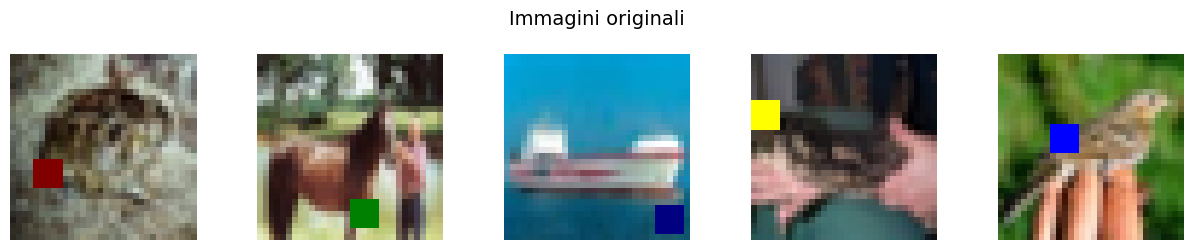

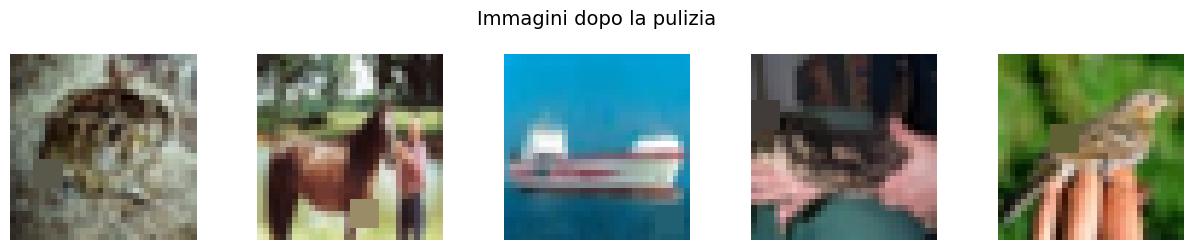

In [6]:
#Funzione di visualizzazione
def visualizza_immagini(imm, num=5, titolo="Immagini"):
    plt.figure(figsize=(num * 2.5, 2.5))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(imm[i])
        plt.axis('off')
    plt.suptitle(titolo, fontsize=14)
    plt.tight_layout()
    plt.show()

visualizza_immagini(X_train, num=5, titolo="Immagini originali")

x_train_cleaned = np.array([remove_uniform_square(img) for img in X_train])
visualizza_immagini(x_train_cleaned, num=5, titolo="Immagini dopo la pulizia")

In [7]:
X_train = X_train.reshape((X_train.shape[0], -1)) / 255.0
X_test = X_test.reshape((X_test.shape[0], -1)) / 255.0

y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("X_train:", X_train.shape)
print("y_train:", y_train_cat.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test_cat.shape)

X_train: (40000, 3072)
y_train: (40000, 10)
X_test: (10000, 3072)
y_test: (10000, 10)


In [9]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(3072,), kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/50
250/250 - 10s - 39ms/step - accuracy: 0.4160 - loss: 1.6990 - val_accuracy: 0.4309 - val_loss: 1.6817
Epoch 2/50
250/250 - 6s - 24ms/step - accuracy: 0.4174 - loss: 1.7014 - val_accuracy: 0.4081 - val_loss: 1.7325
Epoch 3/50
250/250 - 6s - 25ms/step - accuracy: 0.4230 - loss: 1.6896 - val_accuracy: 0.4238 - val_loss: 1.6792
Epoch 4/50
250/250 - 6s - 25ms/step - accuracy: 0.4234 - loss: 1.6947 - val_accuracy: 0.3632 - val_loss: 1.8706
Epoch 5/50
250/250 - 6s - 24ms/step - accuracy: 0.4168 - loss: 1.7077 - val_accuracy: 0.4330 - val_loss: 1.6786
Epoch 6/50
250/250 - 6s - 24ms/step - accuracy: 0.4131 - loss: 1.7247 - val_accuracy: 0.3947 - val_loss: 1.7522
Epoch 7/50
250/250 - 6s - 24ms/step - accuracy: 0.4156 - loss: 1.7204 - val_accuracy: 0.4193 - val_loss: 1.6973
Epoch 8/50
250/250 - 6s - 24ms/step - accuracy: 0.4099 - loss: 1.7201 - val_accuracy: 0.3873 - val_loss: 1.7678
Epoch 9/50
250/250 - 6s - 24ms/step - accuracy: 0.4110 - loss: 1.7208 - val_accuracy: 0.4146 - val_loss

Test Accuracy: 0.4537
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.46      0.51      1000
           1       0.59      0.54      0.56      1000
           2       0.39      0.16      0.23      1000
           3       0.31      0.29      0.30      1000
           4       0.37      0.44      0.40      1000
           5       0.45      0.26      0.33      1000
           6       0.39      0.69      0.50      1000
           7       0.45      0.55      0.50      1000
           8       0.51      0.66      0.58      1000
           9       0.52      0.50      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000



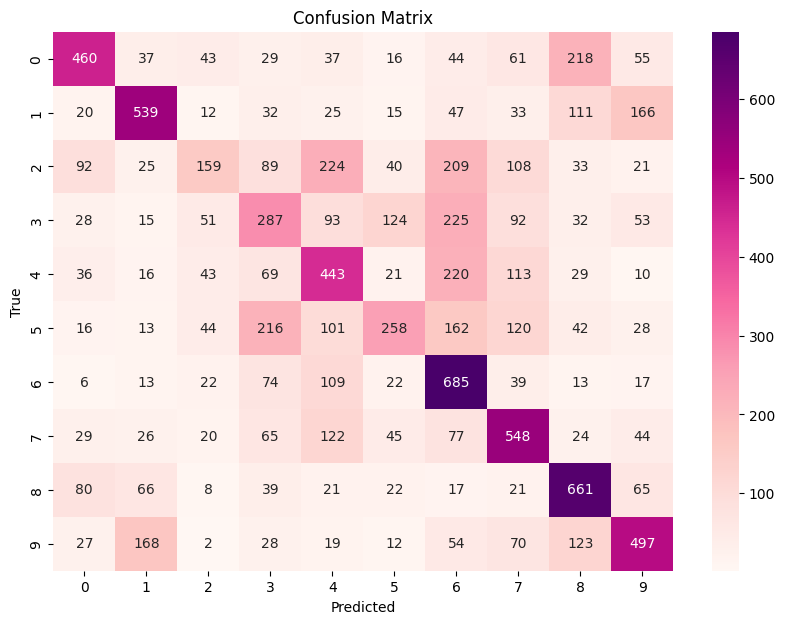

In [13]:
# Accuracy finale
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predizioni e report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='RdPu')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()